In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Imports

In [2]:
import sys
# sys.path.remove('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/master/helper_functions')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/master/helper_functions')

In [3]:
for p in sys.path:
  print(p)


/content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload
/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython
/content/drive/MyDrive/Colab Notebooks/W266 Final Project/master/helper_functions


In [4]:
import pandas as pd
import numpy as np
import time
import pickle


import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec
#https://www.dezyre.com/recipes/use-word2vec#:~:text=How%20to%20use%20word2vec%3F%201%20Import%20the%20necessary,the%20escape%20character%20with%20spaces%20More%20items...%20
#https://radimrehurek.com/gensim_3.8.3/models/word2vec.html
# https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

import parse

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
df = pd.read_csv (r'/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/raw_data_preprocessed.csv')
df.head(2)

,question_id,question_title_raw,question_body_raw,question_body,question_body_text,question_body_code,question_title_body_raw,question_title_body,question_title_body_text,question_title_body_code,answer_id,answer_body_raw,answer_body,answer_text,answer_code,answer_count,view_count,answer_score,is_accepted_answer
0,55661532,"When I run my socket program, there get: `impo...",<p>I write a socket server programmer:</p>\n\n...,I write a socket server programmer:\n#-*- codi...,I write a socket server programmer:\n\nwhen I ...,#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,"When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...",#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,55661630,<p>The answer to your new question is that you...,The answer to your new question is that you ca...,The answer to your new question is that you ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,1816,0,0
1,55661626,"with socket.socket(socket.AF_INET, socket.SOCK...",<p>I have a socket server program:</p>\n\n<pre...,I have a socket server program:\n#!/usr/bin/en...,I have a socket server program:\n\nwhen I run ...,#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,"with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...",#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,55661660,<p>You can't use <code>socket.socket(socket.AF...,"You can't use socket.socket(socket.AF_INET, so...",You can't use with . So that a statement ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,2521,0,1


# Create Column with Reserved Words

In [6]:
#list of reserved words
help('keywords')   #35 reserved words!


Here is a list of the Python keywords.  Enter any keyword to get more help.

False               class               from                or
None                continue            global              pass
True                def                 if                  raise
and                 del                 import              return
as                  elif                in                  try
assert              else                is                  while
async               except              lambda              with
await               finally             nonlocal            yield
break               for                 not                 



In [7]:
#Extract Reserved Words
df.loc[:,'question_body_code_RWords'] = df['question_body_code'].apply(lambda row: parse.extractReservedWords(row), 1)
df.loc[:,'answer_code_RWords'] = df['answer_code'].apply(lambda row: parse.extractReservedWords(row), 1)
df = df.fillna("")

In [8]:
df.head(2)

,question_id,question_title_raw,question_body_raw,question_body,question_body_text,question_body_code,question_title_body_raw,question_title_body,question_title_body_text,question_title_body_code,answer_id,answer_body_raw,answer_body,answer_text,answer_code,answer_count,view_count,answer_score,is_accepted_answer,question_body_code_RWords,answer_code_RWords
0,55661532,"When I run my socket program, there get: `impo...",<p>I write a socket server programmer:</p>\n\n...,I write a socket server programmer:\n#-*- codi...,I write a socket server programmer:\n\nwhen I ...,#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,"When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...",#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,55661630,<p>The answer to your new question is that you...,The answer to your new question is that you ca...,The answer to your new question is that you ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,1816,0,0,as with while if not break in with as in with as,
1,55661626,"with socket.socket(socket.AF_INET, socket.SOCK...",<p>I have a socket server program:</p>\n\n<pre...,I have a socket server program:\n#!/usr/bin/en...,I have a socket server program:\n\nwhen I run ...,#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,"with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...",#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,55661660,<p>You can't use <code>socket.socket(socket.AF...,"You can't use socket.socket(socket.AF_INET, so...",You can't use with . So that a statement ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,2521,0,1,as with while if not break,


In [9]:
ii=50
print(df.question_body_code[ii])
print(".................................................................................")
print(df.question_body_code_RWords[ii])


 def mystery4(s):
      # sig: str -> str 
      i=1
      acc = ""
      while i < len(s):
            if s[i - 1].isdigit(): 
                 acc += s[i]
            i+=1 
      return acc
mystery4("s45ag2f37gs88")5af7g8isdigit()
.................................................................................
def while if return


QUESTION RWords STATS
Min: 0
Max: 267
Average: 5.340045743834526
fraction of zeros: 0.2565300981172103


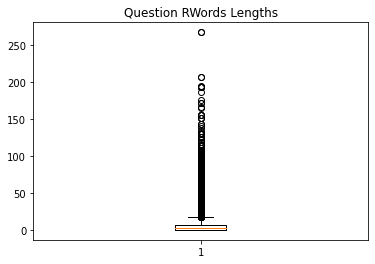

In [10]:
#EDA 

import matplotlib.pyplot as plt

#Get question title lengths
question_RWords_lengths = []
for item in df['question_body_code_RWords']:
    question_RWords_lengths.append(len(str(item).split()))

#Calculate average
question_RWords_lengths_average = sum(question_RWords_lengths)/len(question_RWords_lengths)

#Count # of zeros
zeros=0
for each in question_RWords_lengths:
  if each == 0:
    zeros+=1

print("QUESTION RWords STATS")
print("Min:", min(question_RWords_lengths))
print("Max:", max(question_RWords_lengths))
print("Average:", question_RWords_lengths_average)
print("fraction of zeros:", zeros/len(question_RWords_lengths))

# #Plot histogram
# plt.hist(question_RWords_lengths, density=False, bins=50) 
# plt.ylabel('Count')
# plt.xlabel('Length')
# plt.title('Question RWords Lengths')

#Plot boxplot 
plt.boxplot(question_RWords_lengths) 
plt.title('Question RWords Lengths')
plt.show() 


Answer RWords STATS
Min: 0
Max: 294
Average: 4.405777645186953
fraction of zeros: 0.2705515778308141


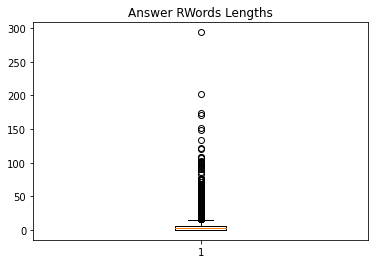

In [11]:
#EDA 

import matplotlib.pyplot as plt

#Get question title lengths
answer_RWords_lengths = []
for item in df['answer_code_RWords']:
    answer_RWords_lengths.append(len(str(item).split()))

#Calculate average
answer_RWords_lengths_average = sum(answer_RWords_lengths)/len(answer_RWords_lengths)

#Count # of zeros
zeros=0
for each in answer_RWords_lengths:
  if each == 0:
    zeros+=1

print("Answer RWords STATS")
print("Min:", min(answer_RWords_lengths))
print("Max:", max(answer_RWords_lengths))
print("Average:", answer_RWords_lengths_average)
print("fraction of zeros:", zeros/len(answer_RWords_lengths))

# #Plot histogram
# plt.hist(answer_RWords_lengths, density=False, bins=50) 
# plt.ylabel('Count')
# plt.xlabel('Length')
# plt.title('Answer RWords Lengths')

#Plot boxplot 
plt.boxplot(answer_RWords_lengths) 
plt.title('Answer RWords Lengths')
plt.show() 


# Create word2vec training data

In [12]:
#Load training dataset
train_from_file = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/q_a_dict_train.pickle', 'rb')
train_qa_dict = pickle.load(train_from_file)
train_question_ids = list(train_qa_dict.keys())
df_train = df[df['question_id'].isin(train_question_ids)]
print(df_train.shape)
df_train = df_train.reset_index()
df_train.head(3)

(48309, 21)


,index,question_id,question_title_raw,question_body_raw,question_body,question_body_text,question_body_code,question_title_body_raw,question_title_body,question_title_body_text,question_title_body_code,answer_id,answer_body_raw,answer_body,answer_text,answer_code,answer_count,view_count,answer_score,is_accepted_answer,question_body_code_RWords,answer_code_RWords
0,0,55661532,"When I run my socket program, there get: `impo...",<p>I write a socket server programmer:</p>\n\n...,I write a socket server programmer:\n#-*- codi...,I write a socket server programmer:\n\nwhen I ...,#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,"When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...",#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,55661630,<p>The answer to your new question is that you...,The answer to your new question is that you ca...,The answer to your new question is that you ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,1816,0,0,as with while if not break in with as in with as,
1,1,55661626,"with socket.socket(socket.AF_INET, socket.SOCK...",<p>I have a socket server program:</p>\n\n<pre...,I have a socket server program:\n#!/usr/bin/en...,I have a socket server program:\n\nwhen I run ...,#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,"with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...",#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,55661660,<p>You can't use <code>socket.socket(socket.AF...,"You can't use socket.socket(socket.AF_INET, so...",You can't use with . So that a statement ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,2521,0,1,as with while if not break,
2,3,55662778,create list with spectial type - Spyder error ...,<p>I want to print <code>&gt;</code> in the sc...,I want to print > in the script 0 to test the ...,I want to print in the script 0 to test the c...,>script[0][4][2]name 'script' is not defined\n...,create list with spectial type - Spyder error ...,create list with spectial type - Spyder error ...,create list with spectial type - Spyder error ...,>script[0][4][2]name 'script' is not defined\n...,55662821,<p>Define list as <code>[]</code> and use <cod...,Define list as [] and use append to add elemen...,Define list as and use to add elements to li...,"[]appendscript = []\n\nscript.append(['A','A',...",2,24,0,1,is not,


In [13]:
#Create training examples (1 example for testing)

#Remove \n characters
idx=9
s_question = df_train.question_body_code_RWords[idx]

#Tokenize data
data_question = []

# Separate by sentences, then separate by tokens
for i in sent_tokenize(s_question):
    temp = []
    for j in word_tokenize(i):
        temp.append(j.lower()) 
    data_question.append(temp)

print(s_question)
print(data_question)

def if if and while and return
[['def', 'if', 'if', 'and', 'while', 'and', 'return']]


In [14]:
train_sentences = []

for idx in range(0,df_train.shape[0]):
  
  #Remove \n characters (if any)
  s_question = df_train.question_body_code_RWords[idx]
  f_question = s_question.replace("\n", " ")
  s_answer = df.answer_code_RWords[idx]
  f_answer = s_answer.replace("\n", " ")

  #Tokenize data
  data_question = []
  data_answer = []
  # Separate by sentences, then separate by tokens
  for i in sent_tokenize(f_question):
      temp = []
      for j in word_tokenize(i):
          temp.append(j.lower()) 
      data_question.append(temp)
  for i in sent_tokenize(f_answer):
      temp = []
      for j in word_tokenize(i):
          temp.append(j.lower())
      data_answer.append(temp)
  
  for each in data_question:
    train_sentences.append(each)
  for each in data_answer:
    train_sentences.append(each)

In [15]:
print(train_sentences[2])

['is', 'not']


In [16]:
print(len(train_sentences))

71064


# Train Word2Vec on Code Reserved Words

In [17]:
#Specify parameters for model

import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print("cores:",cores)

dimension=100 #randomly chosen

model1 = gensim.models. Word2Vec(min_count=1,
                                  window=5,
                                  size=dimension,
                                  # sample=6e-5, 
                                  alpha=0.03, 
                                  min_alpha=0.0007, 
                                  # negative=20,
                                  workers=cores-1)


# min_count = int - Ignores all words with total absolute frequency lower than this - (1, 100)
# window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
# size = int - Dimensionality of the feature vectors. - (50, 300)
# sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
# alpha = float - The initial learning rate - (0.01, 0.05)
# min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
# negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
# workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

model1.save("py2vec.model")

cores: 4


In [18]:
# Build vocabulary
py2vec=Word2Vec.load("py2vec.model")
py2vec.build_vocab(train_sentences, progress_per=10000)
print(py2vec.corpus_count)
py2vec.save("py2vec.model")

71064


In [20]:
# Train
py2vec=Word2Vec.load("py2vec.model")
py2vec.train(train_sentences, total_examples=py2vec.corpus_count, epochs=10)
py2vec.save("py2vec.model")

In [21]:
py2vec.wv.vocab

{'and': <gensim.models.keyedvectors.Vocab at 0x7efec8dc84d0>,
 'as': <gensim.models.keyedvectors.Vocab at 0x7efec8dbac50>,
 'assert': <gensim.models.keyedvectors.Vocab at 0x7efec8dc8350>,
 'async': <gensim.models.keyedvectors.Vocab at 0x7efec8e32050>,
 'await': <gensim.models.keyedvectors.Vocab at 0x7efec8e32bd0>,
 'break': <gensim.models.keyedvectors.Vocab at 0x7efec8dba790>,
 'class': <gensim.models.keyedvectors.Vocab at 0x7efec8dc8650>,
 'continue': <gensim.models.keyedvectors.Vocab at 0x7efec8dc8ad0>,
 'def': <gensim.models.keyedvectors.Vocab at 0x7efec8dba990>,
 'del': <gensim.models.keyedvectors.Vocab at 0x7efec8e32a90>,
 'elif': <gensim.models.keyedvectors.Vocab at 0x7efec8dc81d0>,
 'else': <gensim.models.keyedvectors.Vocab at 0x7efec8dc8e10>,
 'except': <gensim.models.keyedvectors.Vocab at 0x7efec8dc8a90>,
 'false': <gensim.models.keyedvectors.Vocab at 0x7efec8dc8290>,
 'finally': <gensim.models.keyedvectors.Vocab at 0x7efec8e32350>,
 'for': <gensim.models.keyedvectors.Vocab at

In [23]:
# Test Embedding
vector = py2vec.wv['as']  # numpy vector of a word
print(len(vector))
vector

100


array([ 0.33116964, -0.8593574 , -0.39849788,  0.43426967,  0.48803166,
        0.24562761,  0.05766533,  0.5162661 ,  1.0266598 ,  0.43023992,
        0.33334488,  0.09975347, -0.72206444, -0.00282659, -0.7185052 ,
        0.6422036 , -0.50640184, -0.14102434, -0.31589946,  0.08141097,
        0.23734392, -0.17670405, -0.60397184,  0.27200243,  0.17379998,
        1.0604293 ,  0.69769853,  0.330869  ,  0.50750625,  0.47445205,
       -0.48580632,  0.20276922, -0.0708945 ,  1.0657262 ,  0.37505668,
        0.6488644 ,  0.9495542 ,  0.8532058 , -0.66678923,  0.8539627 ,
       -0.69868815,  0.21796803, -0.61982167,  0.27705842,  0.34796613,
       -0.525233  , -0.17567734, -0.20957501,  0.00842515, -0.7359129 ,
        0.6984802 ,  0.6794601 , -0.6402099 , -0.26980266,  0.17161876,
        0.09094764, -0.19532426,  0.01468943, -0.6949068 ,  0.05027886,
        0.01100715, -0.08008123,  0.47111973,  0.640343  , -0.02013281,
        0.06972454,  0.22326246, -0.1301549 ,  0.2809983 , -0.54

In [24]:
vector.shape

(100,)

# Create word2vec embeddings

In [25]:
word2vec_embeddings={}
df.head(2)

,question_id,question_title_raw,question_body_raw,question_body,question_body_text,question_body_code,question_title_body_raw,question_title_body,question_title_body_text,question_title_body_code,answer_id,answer_body_raw,answer_body,answer_text,answer_code,answer_count,view_count,answer_score,is_accepted_answer,question_body_code_RWords,answer_code_RWords
0,55661532,"When I run my socket program, there get: `impo...",<p>I write a socket server programmer:</p>\n\n...,I write a socket server programmer:\n#-*- codi...,I write a socket server programmer:\n\nwhen I ...,#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,"When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...","When I run my socket program, there get: `impo...",#-*- coding:utf-8 -*-\n# Author:sele\n\nimport...,55661630,<p>The answer to your new question is that you...,The answer to your new question is that you ca...,The answer to your new question is that you ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,1816,0,0,as with while if not break in with as in with as,
1,55661626,"with socket.socket(socket.AF_INET, socket.SOCK...",<p>I have a socket server program:</p>\n\n<pre...,I have a socket server program:\n#!/usr/bin/en...,I have a socket server program:\n\nwhen I run ...,#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,"with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...","with socket.socket(socket.AF_INET, socket.SOCK...",#!/usr/bin/env python\n#-*- coding:utf-8 -*-\n...,55661660,<p>You can't use <code>socket.socket(socket.AF...,"You can't use socket.socket(socket.AF_INET, so...",You can't use with . So that a statement ca...,"socket.socket(socket.AF_INET, socket.SOCK_STRE...",2,2521,0,1,as with while if not break,


In [30]:
# Create embeddings of question_ids (average word2vec embeddings by token)

# dimensions of current py2vec model
dimension=len( py2vec.wv['as'])  #lenght of vector of random word

for question_id in df['question_id'].unique():

  # Create list of word2vec embeddings per token
  py2veclist=[]
  for each in word_tokenize(df.question_body_code_RWords[df.question_id == question_id].values[0]):
    py2veclist.append(py2vec.wv[each.lower()])
  
  # Average the embeddings and save to dictionary
  if len(py2veclist) > 0:
    word2vec_embeddings[question_id] = sum(py2veclist)/len(py2veclist)
  else:
    word2vec_embeddings[question_id] = np.zeros(dimension)




# Create embeddings of answer_ids (average word2vec embeddings by token)

for answer_id in df['answer_id'].unique():

  # Create list of word2vec embeddings per token
  py2veclist=[]
  for each in word_tokenize(df.answer_code_RWords[df.answer_id == answer_id].values[0]):
    py2veclist.append(py2vec.wv[each.lower()])
  
  # Average the embeddings and save to dictionary
  if len(py2veclist) > 0:
    word2vec_embeddings[answer_id] = sum(py2veclist)/len(py2veclist)
  else:
    word2vec_embeddings[answer_id] = np.zeros(dimension)


In [37]:
# Save embeddings dictionary to file
embeddings_dict_to_file = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/embeddings/word2vec_embeddings_rwords.pickle', 'wb')
pickle.dump(word2vec_embeddings, embeddings_dict_to_file)

In [38]:
# Load embeddings dictionary from file
embeds_from_file = open('/content/drive/MyDrive/Colab Notebooks/W266 Final Project/data/embeddings/word2vec_embeddings_rwords.pickle', 'rb')
word2vec_embeddings_loaded = pickle.load(embeds_from_file)
len(word2vec_embeddings_loaded)

90959

In [33]:
len(word2vec_embeddings_loaded.keys())

90959

In [34]:

word2vec_embeddings_loaded[55661660].shape

(100,)

In [35]:
word2vec_embeddings_loaded[55661660]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
word2vec_embeddings_loaded[55661626]

array([ 0.33700657, -0.06457988, -0.26575708, -0.04961142,  0.54829985,
       -0.31344977, -0.02129479, -0.10661918,  0.32315835,  0.44962558,
        0.20528223, -0.12616907, -0.25223973, -0.09088141, -0.14125656,
        0.4583139 , -0.22734587, -0.4110603 ,  0.12281788, -0.13669631,
        0.13462557,  0.4314991 , -0.05848671,  0.42244652, -0.0025497 ,
        0.42143664,  0.40203688,  0.16918899,  0.21907134,  0.5220638 ,
        0.21839578, -0.3105192 , -0.6163474 ,  0.52527744, -0.2388037 ,
       -0.67448634, -0.02334585,  0.290639  ,  0.19590604, -0.08450577,
        0.13651784, -0.19941501, -0.3589759 , -0.01417147, -0.41643894,
       -0.28176048,  0.07021081, -0.16607563,  0.14147295, -0.46408263,
        0.20461255, -0.09070662, -0.10740528, -0.17394213, -0.43597007,
        0.02010369,  0.2846104 ,  0.44302413, -0.2138953 ,  0.2725537 ,
        0.28276622,  0.15939616,  0.06956068,  0.1149447 ,  0.06945148,
       -0.53388286,  0.15536164, -0.08653856,  0.03932611, -0.10